In [1]:
#@title Drive Downloader

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

download_with_pydrive = False #@param {type:"boolean"}  

class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()
        
    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)
    
    def download_file(self, file_id, file_dst):
        if self.use_pydrive:
            downloaded = self.drive.CreateFile({'id':file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id $file_id -O $file_dst

downloader = Downloader(download_with_pydrive)

In [1]:
#@title Imports

import clip
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import skimage.io as io
import PIL.Image
from IPython.display import Image 
from enum import Enum



N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]


D = torch.device
CPU = torch.device('cpu')


def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device

current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
os.makedirs(save_path, exist_ok=True)
model_path = os.path.join(save_path, 'transformer_wieghts.pt')


/home/bubble3jh/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#@title Model


class MappingType(Enum):
    MLP = 'mlp'
    Transformer = 'transformer'


class MlpTransformer(nn.Module):
     def __init__(self, in_dim, h_dim, out_d: Optional[int] = None, act=nnf.relu, dropout=0.):
         super().__init__()
         out_d = out_d if out_d is not None else in_dim
         self.fc1 = nn.Linear(in_dim, h_dim)
         self.act = act
         self.fc2 = nn.Linear(h_dim, out_d)
         self.dropout = nn.Dropout(dropout)

     def forward(self, x):
         x = self.fc1(x)
         x = self.act(x)
         x = self.dropout(x)
         x = self.fc2(x)
         x = self.dropout(x)
         return x

class MLP(nn.Module):

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class MultiHeadAttention(nn.Module):

    def __init__(self, dim_self, dim_ref, num_heads, bias=True, dropout=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim_self // num_heads
        self.scale = head_dim ** -0.5
        self.to_queries = nn.Linear(dim_self, dim_self, bias=bias)
        self.to_keys_values = nn.Linear(dim_ref, dim_self * 2, bias=bias)
        self.project = nn.Linear(dim_self, dim_self)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, y=None, mask=None):
        y = y if y is not None else x
        b, n, c = x.shape
        _, m, d = y.shape
        # b n h dh
        queries = self.to_queries(x).reshape(b, n, self.num_heads, c // self.num_heads)
        # b m 2 h dh
        keys_values = self.to_keys_values(y).reshape(b, m, 2, self.num_heads, c // self.num_heads)
        keys, values = keys_values[:, :, 0], keys_values[:, :, 1]
        attention = torch.einsum('bnhd,bmhd->bnmh', queries, keys) * self.scale
        if mask is not None:
            if mask.dim() == 2:
                mask = mask.unsqueeze(1)
            attention = attention.masked_fill(mask.unsqueeze(3), float("-inf"))
        attention = attention.softmax(dim=2)
        out = torch.einsum('bnmh,bmhd->bnhd', attention, values).reshape(b, n, c)
        out = self.project(out)
        return out, attention


class TransformerLayer(nn.Module):

    def forward_with_attention(self, x, y=None, mask=None):
        x_, attention = self.attn(self.norm1(x), y, mask)
        x = x + x_
        x = x + self.mlp(self.norm2(x))
        return x, attention

    def forward(self, x, y=None, mask=None):
        x = x + self.attn(self.norm1(x), y, mask)[0]
        x = x + self.mlp(self.norm2(x))
        return x

    def __init__(self, dim_self, dim_ref, num_heads, mlp_ratio=4., bias=False, dropout=0., act=nnf.relu,
                 norm_layer: nn.Module = nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim_self)
        self.attn = MultiHeadAttention(dim_self, dim_ref, num_heads, bias=bias, dropout=dropout)
        self.norm2 = norm_layer(dim_self)
        self.mlp = MlpTransformer(dim_self, int(dim_self * mlp_ratio), act=act, dropout=dropout)


class Transformer(nn.Module):

    def forward_with_attention(self, x, y=None, mask=None):
        attentions = []
        for layer in self.layers:
            x, att = layer.forward_with_attention(x, y, mask)
            attentions.append(att)
        return x, attentions

    def forward(self, x, y=None, mask=None):
        for i, layer in enumerate(self.layers):
            if i % 2 == 0 and self.enc_dec: # cross
                x = layer(x, y)
            elif self.enc_dec:  # self
                x = layer(x, x, mask)
            else:  # self or cross
                x = layer(x, y, mask)
        return x

    def __init__(self, dim_self: int, num_heads: int, num_layers: int, dim_ref: Optional[int] = None,
                 mlp_ratio: float = 2., act=nnf.relu, norm_layer: nn.Module = nn.LayerNorm, enc_dec: bool = False):
        super(Transformer, self).__init__()
        dim_ref = dim_ref if dim_ref is not None else dim_self
        self.enc_dec = enc_dec
        if enc_dec:
            num_layers = num_layers * 2
        layers = []
        for i in range(num_layers):
            if i % 2 == 0 and enc_dec:  # cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            elif enc_dec:  # self
                layers.append(TransformerLayer(dim_self, dim_self, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            else:  # self or cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
        self.layers = nn.ModuleList(layers)


class TransformerMapper(nn.Module):

    def forward(self, x):
        x = self.linear(x).view(x.shape[0], self.clip_length, -1)
        prefix = self.prefix_const.unsqueeze(0).expand(x.shape[0], *self.prefix_const.shape)
        prefix = torch.cat((x, prefix), dim=1)
        out = self.transformer(prefix)[:, self.clip_length:]
        return out

    def __init__(self, dim_clip: int, dim_embedding: int, prefix_length: int, clip_length: int, num_layers: int = 8):
        super(TransformerMapper, self).__init__()
        self.clip_length = clip_length
        self.transformer = Transformer(dim_embedding, 8, num_layers)
        self.linear = nn.Linear(dim_clip, clip_length * dim_embedding)
        self.prefix_const = nn.Parameter(torch.randn(prefix_length, dim_embedding), requires_grad=True)


class ClipCaptionModel(nn.Module):

    def get_dummy_token(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: torch.Tensor, prefix: torch.Tensor, mask: Optional[torch.Tensor] = None,
                labels: Optional[torch.Tensor] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, clip_length: Optional[int] = None, prefix_size: int = 512,
                 num_layers: int = 8, mapping_type: MappingType = MappingType.MLP):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if mapping_type == MappingType.MLP:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2,
                                     self.gpt_embedding_size * prefix_length))
        else:
            self.clip_project = TransformerMapper(prefix_size, self.gpt_embedding_size, prefix_length,
                                                                     clip_length, num_layers)


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

In [3]:
#@title Caption prediction

def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts


def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

In [4]:
#@title GPU/CPU


is_gpu = True #@param {type:"boolean"}  


In [5]:
#@title CLIP model + GPT2 tokenizer

device = CUDA(0) if is_gpu else "cpu"
clip_model, preprocess = clip.load("RN50x4", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [7]:
#@title Load model weights

model_path = '/data1/bubble3jh/Fair-Diffusion/ieat/data/pretrained_models/transformer_weights.pt'
prefix_length = 40

model = ClipCaptionPrefix(prefix_length, clip_length=40, prefix_size=640,
                                  num_layers=8, mapping_type='transformer')
model.load_state_dict(torch.load(model_path, map_location=CPU), strict=False) 

model = model.eval() 
device = CUDA(0) if is_gpu else "cpu"
model = model.to(device)


In [10]:
import os
import json
from skimage import io
import PIL
import torch

# 이미지 파일과 캡션을 저장할 딕셔너리
captions_dict = {}
use_beam_search = True

# 시작 디렉토리 경로 설정
start_directory_path = '.'

# 모든 디렉토리와 하위 디렉토리를 순회
for directory_name, _, file_list in os.walk(start_directory_path):
    if directory_name == start_directory_path:  # 최상위 디렉토리는 제외
        continue
    for file_name in file_list:
        # 파일 확장자가 이미지 형식인지 확인 (예: jpg, png)
        if not file_name.endswith(('.json')):
            image_path = os.path.join(directory_name, file_name)

            # 이미지 읽기
            image = io.imread(image_path)
            try:
                pil_image = PIL.Image.fromarray(image)
            except:
                print(image_path)
            # display(pil_image)

            # 이미지 전처리 및 캡션 생성
            image = preprocess(pil_image).unsqueeze(0).to(device)

            with torch.no_grad():
                # if type(model) is ClipCaptionE2E:
                #     prefix_embed = model.forward_image(image)
                # else:
                prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
                prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
            if use_beam_search:
                generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
            else:
                generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)
            captions_dict[image_path] = generated_text_prefix
            # 캡션 출력
            print(file_name, generated_text_prefix)
output_path = './captions.json'
with open(output_path, 'w') as json_file:
    json.dump(captions_dict, json_file)

print(f"Captions saved to {output_path}")

/tmp/ipykernel_3641413/2332459524.py:42: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_tokens_source = next_tokens // scores_sum.shape[1]


AFE831.jpg A black and white photo of a person with a hat on.
AFE851.jpg A picture of a man with a hat on his head.
AME831.jpg A black and white photo of a man with a hat on his head.
AME871.jpg A picture of a man with a hat on his head.
AFE811.jpg A black and white photo of a woman sitting on a chair.
AME821.jpg A black and white photo of a man with a hat on his head.
AME0012.jpg A view of a street sign on the side of a road.
AME003.jpg A view of the White House from the top of a building.
AME002.jpg A large dome with a large star in the center of it.
AME009.jpg A large statue of the Statue of Liberty standing on top of a building.
AME006.jpg A view of a bridge over the water.
AME0016.jpg A tall tower with a clock on top of it.
AME041.jpg A picture of a man in a suit and tie.
AFE021.jpg A black and white photo of a person with a hat and sunglasses.
AFE081.jpg A black and white photo of a woman with a hat on her head.
AME021.jpg A picture of a man with a hat on his head.
AFE071.jpg A b

/mlainas/bubble3jh/anaconda3/envs/farcon/lib/python3.8/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


christianity1_google.png A black and white photo of a black and white sign.
church2_google.jpg A church in front of a church with a clock on it.
bible1_google.jpg A book that is sitting on top of a rack.
church1_google.jpg A white church with a clock on top of it.
christian3_google.jpg A man standing in front of a church.
49_google.jpg A woman sitting in a chair next to a table.
48_google.jpg a close up of a woman with a pink lip.
11_google.jpg A woman sitting on top of a white bed.
3_google.jpg A man in a black shirt and tie poses for a picture.
53_google.jpg A man poses for a picture with a cell phone.
8_google.jpg A man holding a cup of coffee in his hand.
51_google.jpg a close up of a woman with glasses on.
9_google.jpg A woman holding a cup of coffee in her hand.
26_google.jpg a close up of a close up of a woman's neck.
6_google.jpg A woman is posing in front of a fence.
21_google.jpg a close up of a woman with glasses on.
7_google.jpg A little boy is holding a cell phone in his h

In [16]:
import json

# 기존 JSON 파일 경로
input_path = './captions.json'

# 변환된 내용을 저장할 JSON 파일 경로
output_path = './transformer_coco_captions_modified.json'

# 기존 JSON 파일 읽기
with open(input_path, 'r') as json_file:
    captions_dict = json.load(json_file)

# 이미지 파일과 캡션을 저장할 리스트
captions_list = []

# 딕셔너리의 키와 값을 순회하며 리스트에 추가
for image_path, caption in captions_dict.items():
    image_caption_pair = {
        "image_path": image_path,
        "caption": caption
    }
    captions_list.append(image_caption_pair)

# 새로운 구조로 JSON 파일 저장
with open(output_path, 'w') as json_file:
    json.dump(captions_list, json_file)

print(f"Captions saved to {output_path}")

Captions saved to ./transformer_coco_captions_modified.json


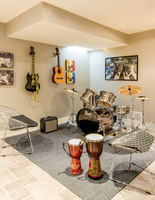

A living room filled with guitars and a piano.


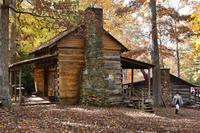

A view of a wood cabin with a wooden bench.


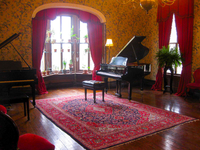

A room filled with chairs and a piano.


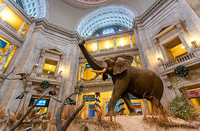

A statue of an elephant in a museum display.


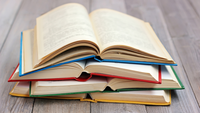

A book sitting on top of a stack of books.


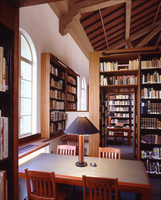

A library sitting on top of a table in front of a bookshelf.


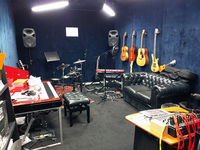

A room with a bunch of guitars and a keyboard.


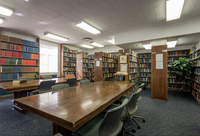

A table with a table and chairs in front of it.


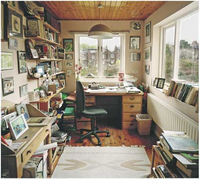

A room filled with books, a desk, and a computer.


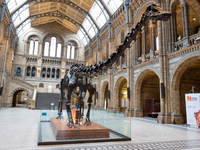

A large statue of a bird in front of a glass window.


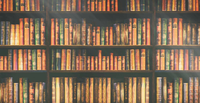

A bunch of books stacked on top of each other.


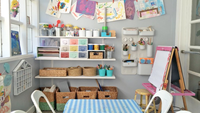

A children's room filled with various items.


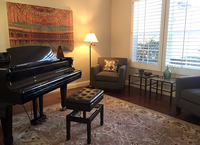

A living room filled with furniture and a piano.


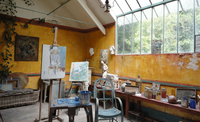

A room filled with lots of paintings on a wall.


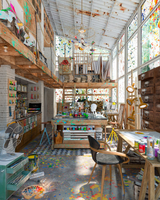

A room filled with lots of chairs and tables.


In [10]:
import json
from IPython.display import display, clear_output
from PIL import Image
import time

# JSON 데이터 읽기 (예를 들어, 'data.json' 파일에서)
with open('transformer_coco_captions_modified.json') as f:
    data = json.load(f)

subset_data = [item for item in data if './gender/liberal-arts' in item['image_path']]

#이미지와 캡션 하나씩 표시
for item in subset_data:
    image_path = item["image_path"]
    caption = item["caption"]
    image = Image.open(image_path)
        # 이미지 크기 조정
    max_size = (200, 200) # 원하는 크기로 설정
    image.thumbnail(max_size, Image.ANTIALIAS)
    
    display(image)
    print(caption)

In [1]:
import os
import json

# 디렉토리 구조
# directories = [
#     'age/old', 'age/young',
#     'arab-muslim/arab-muslim', 'arab-muslim/other-people',
#     'asian/american', 'asian/asian-american', 'asian/european-american', 'asian/foreign',
#     'disabled/abled', 'disabled/disabled', 'disabled/disabled-people',
#     'gender/career', 'gender/family', 'gender/female', 'gender/liberal-arts', 'gender/male', 'gender/science',
#     'insect-flower/flower', 'insect-flower/insect',
#     'intersectional/black', 'intersectional/black-female', 'intersectional/black-male', 'intersectional/female', 'intersectional/male', 'intersectional/white', 'intersectional/white-female', 'intersectional/white-male',
#     'native/euro', 'native/native', 'native/us', 'native/world',
#     'presidents/bush', 'presidents/clinton', 'presidents/kennedy', 'presidents/lincoln', 'presidents/trump',
#     'race/african-american', 'race/african-american-female', 'race/african-american-male', 'race/european-american', 'race/european-american-female', 'race/european-american-male',
#     'religion/christianity', 'religion/judaism',
#     'sexuality/gay', 'sexuality/straight',
#     'skin-tone/dark', 'skin-tone/light',
#     'valence/pleasant', 'valence/pleasant-1', 'valence/unpleasant', 'valence/unpleasant-1',
#     'weapon/black', 'weapon/tool', 'weapon/tool-modern', 'weapon/weapon', 'weapon/weapon-modern', 'weapon/white',
#     'weight/fat', 'weight/thin'
# ]
directories =['american_race/african-american-google',
'american_race/asian-american-google',
'american_race/european-american-google'
]
# 주어진 JSON 데이터
with open('conception_captions_modified.json') as f:
    data = json.load(f)


# 각 디렉토리에 대해 처리
for directory in directories:
    subset_data = [item for item in data if './' + directory + '/' in item['image_path']]
    
    # 해당 디렉토리에 대한 캡션 파일 경로
    output_path = os.path.join(directory, 'captions.json')

    # 디렉토리 생성 (없으면)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # 결과를 JSON 파일로 저장
    with open(output_path, 'w') as file:
        json.dump(subset_data, file)

    print(f'{len(subset_data)} captions saved to {output_path}')

55 captions saved to american_race/african-american-google/captions.json
55 captions saved to american_race/asian-american-google/captions.json
55 captions saved to american_race/european-american-google/captions.json


In [6]:
# Let's assume we have a JSON file named 'coco_captions_modified.json'
# Since we don't have an actual file, this is a placeholder path
json_file_path = '/data1/bubble3jh/git_FarconVAE/data/mm_experiments_added/arab-muslim/arab-muslim/captions.json'

# This code will open the JSON file and count the number of entries
import json

# Assuming 'coco_captions_modified.json' is the file we want to read from
try:
    with open(json_file_path, 'r') as file:
        data = json.load(file)
        entry_count = len(data)
except FileNotFoundError:
    entry_count = "File not found. Please make sure the JSON file path is correct."
except json.JSONDecodeError:
    entry_count = "File could not be decoded. Please make sure the JSON file is properly formatted."

entry_count

53